In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab Notebooks/"
base_dir = Path(root_dir + 'Vegetable Classifier/')
os.chdir(base_dir)
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
cleaned.csv	    downloads  page.txt    vegetable_classifier.ipynb
download_datset.py  models     util_files


## Read Dataset
- Dataset images are stored in "downloads/<label_name> folders"
- Each folder contains 50 images of the respective vegetable, downloaded from GoogleImages.
- There is no seperate validation set.

In [0]:
dataset_path = base_dir/'downloads'
data = ImageDataBunch.from_folder(dataset_path, valid_pct=0.2, ds_tfms=get_transforms(), size=224, bs=64).normalize(imagenet_stats)

In [0]:
# Set the valid_pct above to 0, made a cleaned.csv file of all the data. Removed rows that were bad manually and updated the cleaned.csv

from fastai.widgets import DatasetFormatter, ImageCleaner
ds, idxs = DatasetFormatter().from_toplosses(learn)
ImageCleaner(ds, idxs, base_dir)

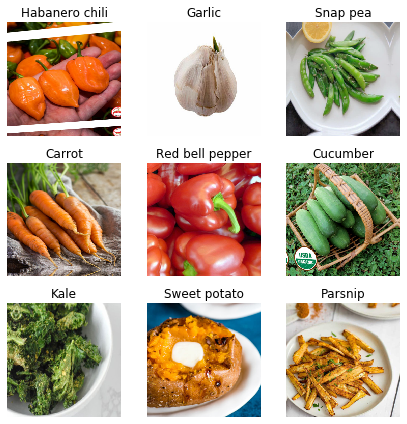

In [0]:
data.show_batch(rows=3, figsize=(6,6))

In [0]:
print(data.classes)
print(len(data.classes), data.c)

['Artichoke', 'Arugula', 'Asparagus', 'Avocado', 'Baby Carrot', 'Beet', 'Bell pepper', 'Black Beans', 'Broccoli', 'Brussels sprout', 'Cabbage', 'Carrot', 'Cauliflower', 'Celery', 'Chives', 'Corn', 'Cucumber', 'Edamame', 'Eggplant', 'Garlic', 'Ginger', 'Green bean', 'Green bell pepper', 'Habanero chili', 'JalapeÃ±o', 'Kale', 'Leek', 'Lettuce', 'Lima Bean', 'Mushroom', 'Olives', 'Onion', 'Parsnip', 'Pea', 'Pinto Beans', 'Potato', 'Pumpkin', 'Radish', 'Red Cabbage', 'Red bell pepper', 'Red onion', 'Romaine lettuce', 'Snap pea', 'Spinach', 'Squash', 'Sweet potato', 'Turnip', 'Yams', 'Yellow onion', 'Zucchini']
50 50


In [0]:
for label in data.classes:
  path_for_label = base_dir/'downloads'/label
  verify_images(path_for_label)

## Train CNN Model
### Lets use ResNet34 - Proven Model

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 173MB/s]


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,4.464159,2.054041,0.542914,00:55
1,2.832616,1.575778,0.439122,00:55
2,1.980232,1.470686,0.405190,00:56
3,1.497285,1.438437,0.389222,00:55


In [0]:
learn.save(Path(base_dir/'models'/'stage-1'), with_opt=True,return_path=True)

PosixPath('/content/gdrive/My Drive/Colab Notebooks/Vegetable Classifier/models/stage-1.pth')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

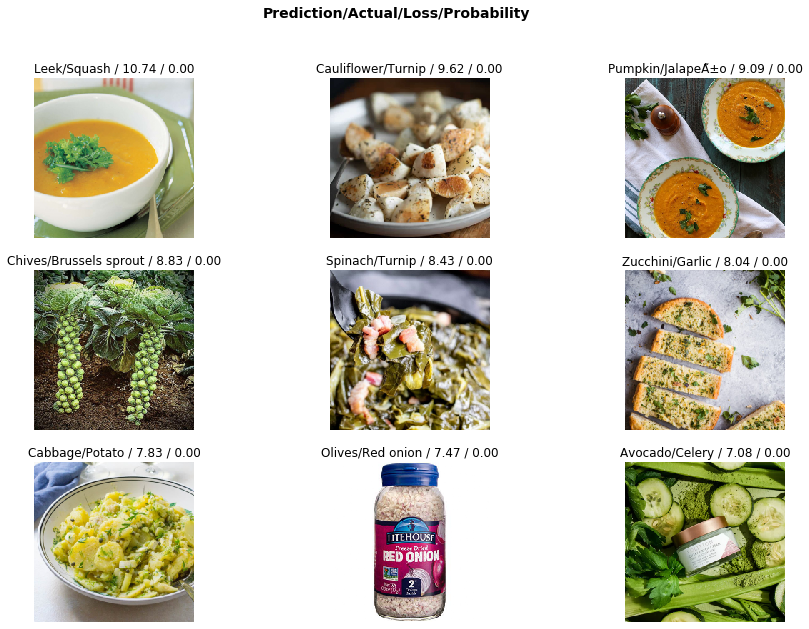

In [0]:
interp.plot_top_losses(9, figsize=(15,10))

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.983408,1.503839,0.377246,00:53


In [0]:
learn.load(Path(base_dir/'models'/'stage-1'))

Learner(data=ImageDataBunch;

Train: LabelList (2005 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Arugula,Arugula,Arugula,Arugula,Arugula
Path: /content/gdrive/My Drive/Colab Notebooks/Vegetable Classifier/downloads;

Valid: LabelList (501 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Spinach,Radish,Carrot,Black Beans,Asparagus
Path: /content/gdrive/My Drive/Colab Notebooks/Vegetable Classifier/downloads;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 6

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


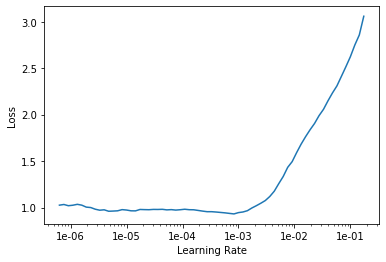

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.215005,0.973446,0.269461,00:48
1,1.155235,1.304421,0.335329,00:49
2,0.928531,1.117927,0.315369,00:48
3,0.677828,1.067935,0.295409,00:48


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


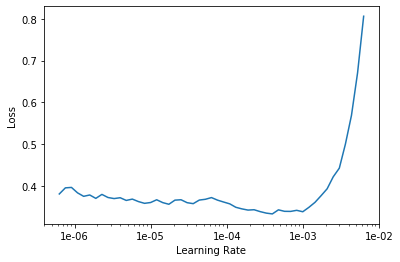

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, max_lr=slice(8e-5, 7e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.367135,1.045022,0.273453,00:49
1,0.358891,1.141151,0.287425,00:49
2,0.359499,1.335297,0.339321,00:49
3,0.421164,1.295356,0.333333,00:49
4,0.411652,1.356652,0.319361,00:49
5,0.359671,1.329741,0.317365,00:49
6,0.297910,1.241390,0.309381,00:49
7,0.235546,1.231472,0.293413,00:49
8,0.182898,1.224313,0.299401,00:49
9,0.148413,1.227979,0.289421,00:49


In [0]:
learn.fit_one_cycle(20, max_lr=slice(2e-6, 1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.130628,1.222499,0.287425,00:48
1,0.118995,1.227719,0.281437,00:49
2,0.107843,1.230842,0.283433,00:49
3,0.109482,1.217466,0.287425,00:49
4,0.102318,1.216764,0.283433,00:49
5,0.100878,1.222339,0.291417,00:49
6,0.099337,1.218562,0.283433,00:50
7,0.105520,1.218382,0.281437,00:49
8,0.103562,1.227048,0.285429,00:49
9,0.101629,1.223456,0.277445,00:49


In [0]:
learn.save(Path(base_dir/'models'/'stage-2'), with_opt=True,return_path=True)

PosixPath('/content/gdrive/My Drive/Colab Notebooks/Vegetable Classifier/models/stage-2.pth')

In [0]:
learn.load(Path(base_dir/'models'/'stage-2'))

Learner(data=ImageDataBunch;

Train: LabelList (2005 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Arugula,Arugula,Arugula,Arugula,Arugula
Path: /content/gdrive/My Drive/Colab Notebooks/Vegetable Classifier/downloads;

Valid: LabelList (501 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Celery,Romaine lettuce,Avocado,Cauliflower,Carrot
Path: /content/gdrive/My Drive/Colab Notebooks/Vegetable Classifier/downloads;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d

In [0]:
learn.fit_one_cycle(1, max_lr=1e-6)

epoch,train_loss,valid_loss,error_rate,time
0,0.363546,0.294155,0.085828,06:05


In [0]:
from fastai.widgets import DatasetFormatter, ImageCleaner
ds, idxs = DatasetFormatter().from_toplosses(learn)
ImageCleaner(ds, idxs, base_dir/'downloads')

In [0]:
doc(ImageCleaner)